# CGS402A Assignment 1
Team memebers:  
1. Akash Biswas (Roll no.: 200074)
2. Ayush Agrawal (Roll no.: 200237)
3. Meet Solanki  (Roll no.: 200579)

In this assignment we try to break existing noCAPTCHA systems by Google. Later on we suggest changes to make the noCAPTCHA more secure in accordance with Fitts' Law.  

The notebook requires few resources which can be found [here](https://drive.google.com/drive/folders/1iR_EkGBW_PWLPC4gYOSNfYmjRtXfEyE9?usp=sharing).  
Make sure to download the folder and run the notebook inside the directory.

## Experiment
To collect data we have designed an experiment wherein, a human user is presented with a reCAPTCHA box. The user is required to click on the reCAPTCHA box. This is repeated for a number of times.  

The experiment records the initial position of mouse cursor and the position when the user clicks the reCAPTCHA box and the time required in doing the task.

In [1]:
# import the required libraries
import pygame
import random
import time

pygame 2.1.2 (SDL 2.0.16, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
pygame.init()
# This experiment was designed for system with display resolution of 1920,1080 feel free to change the resolution accordingly
screen = pygame.display.set_mode((1920, 1080))
pygame.display.set_caption("CGS402 CAPTCHA Experiment")

# Load the images from the directory shared above
captcha = pygame.image.load('./noCAPTCHA.jpg')
captcha_rect = captcha.get_rect()
captcha_rect.x = random.randrange(0, 1616)
captcha_rect.y = random.randrange(0, 982)

captcha_t = pygame.image.load('./noCAPTCHA_tick.jpg')

def player(img, img_rect):
    screen.blit(img, img_rect)

# Change # of trials
run = 100
temp_st = str(pygame.mouse.get_pos()[0]) + "," + str(pygame.mouse.get_pos()[1]) + ","
with open("./result.csv", "w") as f:
    f.write("Init_x,Init_y,Fin_x,Fin_y,Time\n")
    tic = time.time()
    while run>0: 
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                run = False
            if event.type == pygame.MOUSEBUTTONDOWN:
                if captcha_rect.collidepoint(event.pos):
                    toc = time.time()
                    temp_st += str(pygame.mouse.get_pos()[0]) + "," + str(pygame.mouse.get_pos()[1]) + "," + str(toc - tic) + "\n"
                    f.write(temp_st)
                    screen.fill((255,255,255))
                    player(captcha_t, captcha_rect)
                    pygame.display.update()
                    time.sleep(1)
                    temp_st = str(pygame.mouse.get_pos()[0]) + "," + str(pygame.mouse.get_pos()[1]) + ","
                    captcha_rect.x = random.randrange(0, 1616)
                    captcha_rect.y = random.randrange(0, 982)
                    tic = time.time()
                    run-=1


        screen.fill((255, 255, 255))
        player(captcha, captcha_rect)
        pygame.display.update()


: 

## Data Analysis
Now that we have the data, its time for data analysis.

In [2]:
# import the required libraries
import numpy as np
import pandas as pd

In [5]:
# Can use given sample.out.csv data provided in directory
data = pd.read_csv("./result.csv")
data

,Init_x,Init_y,Fin_x,Fin_y,Time
0,0,0,1153,356,1.111015
1,1153,356,938,704,1.283931
2,938,704,152,231,1.106309
3,152,231,644,257,1.144405
4,644,257,1336,234,1.054781
...,...,...,...,...,...
195,174,102,933,257,1.716138
196,933,257,1106,487,1.168797
197,1106,487,1255,615,1.329718
198,1255,615,1331,390,1.292648


First, we plot Time taken vs. Manhattan distance between initial and final points.

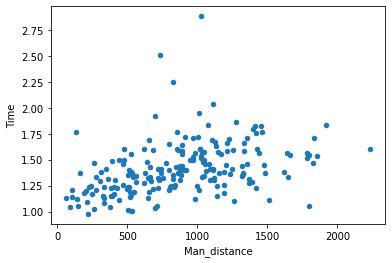

In [6]:
data['Man_distance'] = abs(data['Init_x'] - data['Fin_x']) + abs(data['Init_y'] - data['Fin_y'])
ax1 = data.plot.scatter(x='Man_distance', y='Time')

Now, we move to Euclidean distance and plot it.

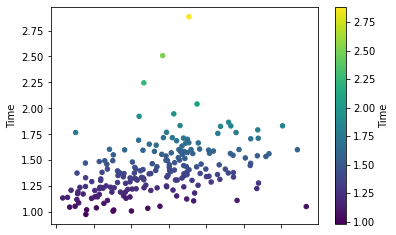

In [7]:
data['Distance'] = np.sqrt(np.square(data['Init_x'] - data['Fin_x']) + np.square(data['Init_y'] - data['Fin_y']))
ax1 = data.plot.scatter(x='Distance', y='Time',c='Time',colormap='viridis')

For small distances, the plot is similar for both the cases. But differences widen for large distances as  

$\frac{|a| + |b|}{2} \leq \sqrt{a^2 + b^2}$  

And by triangle inequality, we have  

$\sqrt{a^2 + b^2} \leq |a| + |b|$ 

So, we train our model with Euclidean distance instead.

## Model
As, we observe form the plot that the time taken increses with the distance. So, a Linear Regression model should do the work.

In [8]:
from sklearn .linear_model import LinearRegression

X = data['Distance'].values.reshape(-1,1)
y = data['Time'].values.reshape(-1,1)
reg = LinearRegression().fit(X,y)

## Breaking noCAPTCHA
Now, that we have collected, analysed the data and created a model, its time to use it. 

For automating the task, we use selenium library with Chromedriver. So, before running the system make sure to download the Chromedriver of appropriate version from [here](https://chromedriver.chromium.org/downloads).

In [9]:
from selenium import webdriver
from selenium.webdriver.common.by import By

In [10]:
# Apply appropriate options in the driver
options = webdriver.ChromeOptions()
options.add_experimental_option("useAutomationExtension", False)
options.add_experimental_option("excludeSwitches",["enable-automation"])
driver = webdriver.Chrome(executable_path="./chromedriver", chrome_options=options)

/tmp/ipykernel_14072/2198113746.py:5: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path="./chromedriver", chrome_options=options)
/tmp/ipykernel_14072/2198113746.py:5: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(executable_path="./chromedriver", chrome_options=options)


In [11]:
# Feel free to check out other urls as well 
# url = "http://127.0.0.1:8080/"
# url = "https://patrickhlauke.github.io/recaptcha/"
url = "https://www.google.com/recaptcha/api2/demo"

In [12]:
import pyautogui

# set times to 0 to get minimum latency
pyautogui.MINIMUM_DURATION = 0
pyautogui.MINIMUM_SLEEP = 0
pyautogui.PAUSE = 0

As, with pyautogui, we can move the cursor in linear path which is more robotic, so we use another library bezier to move the cursor in a curved path.  
Ref: https://stackoverflow.com/questions/44467329/pyautogui-mouse-movement-with-bezier-curve

In [13]:
import bezier

In [18]:
driver.get(url)
driver.fullscreen_window()

cap_frame = (driver.find_element(By.CSS_SELECTOR,"iframe[name^='a-'][src^='https://www.google.com/recaptcha/api2/anchor?']"))
x=cap_frame.location
driver.switch_to.frame(cap_frame)
cap = driver.find_element(By.XPATH, "//*[@id='rc-anchor-container']")

y=cap.size
x['y'] += y['height']/2
x['x'] += y['width']/10

start = pyautogui.position()
end = x['x'], x['y']
eucl_dist = np.sqrt(np.square(start[0] - end[0]) + np.square(start[1] - end[1]))

control1 = end[0], start[1]
control2 = start[0], end[1]

control_points = np.array([start, control1, control2, end])
points = np.array([control_points[:,0], control_points[:,1]])

# You can set the degree of the curve here, should be less than # of control points
degree = 3
# Create the bezier curve
curve = bezier.Curve(points, degree)
# You can also create it with using Curve.from_nodes(), which sets degree to len(control_points)-1
# curve = bezier.Curve.from_nodes(points)
curve_steps = 50  # How many points the curve should be split into. Each is a separate pyautogui.moveTo() execution
exp_time = max((reg.predict(np.array([[eucl_dist]])))[0][0]-0.2, 0.8) # Assume there is latency of 0.2 s for the operations
delay = exp_time/curve_steps  

for i in range(1, curve_steps+1):
    # The evaluate method takes a float from [0.0, 1.0] and returns the coordinates at that point in the curve
    # Another way of thinking about it is that i/steps gets the coordinates at (100*i/steps) percent into the curve
    x, y = curve.evaluate(i/curve_steps)
    pyautogui.moveTo(x, y)  # Move to point in curve
    pyautogui.sleep(delay)  # Wait delay

pyautogui.click()

## Improvements
The noCAPTCHA verification presents the user with box of fixed size to click. Also, the location of noCAPTCHA box remains fixed for a site.

Consider the case if users are presented with a version of noCAPTCHA box of variable size at random location on the screen.  
As, the model we have designed takes only the Euclidean distance between the points as parameter, should not be able to crack this version according to [Fitts' Law](https://en.wikipedia.org/wiki/Fitts%27s_law).  

So, to break this verification system we also have to take into account the size of the verification box and train our new model accordingly.

## Simulation in accordance with Fitts' Law
We have changed our previous experiment slightly so that the user is presented with CAPTCHA box scaled randomly.

In [ ]:
pygame.init()
screen = pygame.display.set_mode((1920, 1080))
pygame.display.set_caption("CGS402 CAPTCHA Experiment Fitts' Law")

scale = random.uniform(0.4,1)

captcha_o = pygame.image.load('./noCAPTCHA.jpg')
captcha = pygame.transform.scale(captcha_o, (int(captcha_o.get_size()[0]*scale), int(captcha_o.get_size()[1]*scale)))
captcha_rect = captcha.get_rect()
captcha_rect.x = random.randrange(0, 1616)
captcha_rect.y = random.randrange(0, 982)

captcha_t_o = pygame.image.load('./noCAPTCHA_tick.jpg')
captcha_t = pygame.transform.scale(captcha_t_o, (int(captcha_t_o.get_size()[0]*scale), int(captcha_t_o.get_size()[1]*scale)))

def player(img, img_rect):
    screen.blit(img, img_rect)

run = 5
temp_st = str(pygame.mouse.get_pos()[0]) + "," + str(pygame.mouse.get_pos()[1]) + ","
with open("./result_fitt.csv", "w") as f:
    f.write("Init_x,Init_y,Fin_x,Fin_y,Height,Width,Time\n")
    tic = time.time()
    while run>0: 
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                run = False
            if event.type == pygame.MOUSEBUTTONDOWN:
                if captcha_rect.collidepoint(event.pos):
                    toc = time.time()
                    temp_st += str(pygame.mouse.get_pos()[0]) + "," + str(pygame.mouse.get_pos()[1]) + "," + str(captcha.get_height()) + "," + str(captcha.get_width()) + "," + str(toc - tic) + "\n"
                    f.write(temp_st)
                    screen.fill((255,255,255))
                    player(captcha_t, captcha_rect)
                    pygame.display.update()
                    time.sleep(1)
                    temp_st = str(pygame.mouse.get_pos()[0]) + "," + str(pygame.mouse.get_pos()[1]) + ","
                    scale = random.uniform(0.3,1)
                    captcha = pygame.transform.scale(captcha_o, (int(captcha_o.get_size()[0]*scale), int(captcha_o.get_size()[1]*scale)))
                    captcha_t = pygame.transform.scale(captcha_t_o, (int(captcha_t_o.get_size()[0]*scale), int(captcha_t_o.get_size()[1]*scale)))
                    captcha_rect = captcha.get_rect()
                    captcha_rect.x = random.randrange(0, 1616)
                    captcha_rect.y = random.randrange(0, 982)
                    tic = time.time()
                    run-=1


        screen.fill((255, 255, 255))
        player(captcha, captcha_rect)
        pygame.display.update()
